$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
$$

# Part 1: Mini-Project
<a id=part3></a>

In this part you'll implement a small comparative-analysis project, heavily based on the materials from the tutorials and homework.

### Guidelines

- You should implement the code which displays your results in this notebook, and add any additional code files for your implementation in the `project/` directory. You can import these files here, as we do for the homeworks.
- Running this notebook should not perform any training - load your results from some output files and display them here. The notebook must be runnable from start to end without errors.
- You must include a detailed write-up (in the notebook) of what you implemented and how. 
- Explain the structure of your code and how to run it to reproduce your results.
- Explicitly state any external code you used, including built-in pytorch models and code from the course tutorials/homework.
- Analyze your numerical results, explaining **why** you got these results (not just specifying the results).
- Where relevant, place all results in a table or display them using a graph.
- Before submitting, make sure all files which are required to run this notebook are included in the generated submission zip.
- Try to keep the submission file size under 10MB. Do not include model checkpoint files, dataset files, or any other non-essentials files. Instead include your results as images/text files/pickles/etc, and load them for display in this notebook. 

## Object detection on TACO dataset

TACO is a growing image dataset of waste in the wild. It contains images of litter taken under diverse environments: woods, roads and beaches.

<center><img src="imgs/taco.png" /></center>


you can read more about the dataset here: https://github.com/pedropro/TACO

and can explore the data distribution and how to load it from here: https://github.com/pedropro/TACO/blob/master/demo.ipynb


The stable version of the dataset that contain 1500 images and 4787 annotations exist in `datasets/TACO-master`
You do not need to download the dataset.


### Project goals:

* You need to perform Object Detection task, over 7 of the dataset.
* The annotation for object detection can be downloaded from here: https://github.com/wimlds-trojmiasto/detect-waste/tree/main/annotations.
* The data and annotation format is like the COCOAPI: https://github.com/cocodataset/cocoapi (you can find a notebook of how to perform evalutation using it here: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb)
(you need to install it..)
* if you need a beginner guild for OD in COCOAPI, you can read and watch this link: https://www.neuralception.com/cocodatasetapi/ 

### What do i need to do?

* **Everything is in the game!** as long as your model does not require more then 8 GB of memory and you follow the Guidelines above.


### What does it mean?
* you can use data augmentation, rather take what's implemented in the directory or use external libraries such as https://albumentations.ai/ (notice that when you create your own augmentations you need to change the annotation as well)
* you can use more data if you find it useful (for examples, reviwew https://github.com/AgaMiko/waste-datasets-review)


### What model can i use?
* Whatever you want!
you can review good models for the coco-OD task as a referance:
SOTA: https://paperswithcode.com/sota/object-detection-on-coco
Real-Time: https://paperswithcode.com/sota/real-time-object-detection-on-coco
Or you can use older models like YOLO-V3 or Faster-RCNN
* As long as you have a reason (complexity, speed, preformence), you are golden.

### Tips for a good grade:
* start as simple as possible. dealing with APIs are not the easiest for the first time and i predict that this would be your main issue. only when you have a running model that learn, you can add learning tricks.
* use the visualization of a notebook, as we did over the course, check that your input actually fitting the model, the output is the desired size and so on.
* It is recommanded to change the images to a fixed size, like shown in here :https://github.com/pedropro/TACO/blob/master/detector/inspect_data.ipynb
* Please adress the architecture and your loss function/s in this notebook. if you decided to add some loss component like the Focal loss for instance, try to show the results before and after using it.
* Plot your losses in this notebook, any evaluation metric can be shown as a function of time and possibe to analize per class.

Good luck!

## Implementation

**TODO**: This is where you should write your explanations and implement the code to display the results.
See guidelines about what to include in this section.

#### Imports:

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

import unittest
import colorsys
import pathlib
import urllib
import shutil
import random
import pickle
import pylab
import json
import sys
import os
import re

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from pycocotools.coco import COCO
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from PIL import Image, ExifTags

%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Using GPU:

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: cuda


## Getting familiar with the TACO Dataset:

#### Loading the dataset:

In [3]:
dataset_path = '/datasets/TACO-master/data/'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Loads dataset as a coco object
coco = COCO(anns_file_path)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


#### Number of images, categories and annotations:

In [4]:
cat_ids = coco.getCatIds()
image_ids = coco.getImgIds()
annotation_ids = coco.getAnnIds()

num_cats = len(cat_ids)
num_images = len(image_ids)
num_annotations = len(annotation_ids)

print("Number of categories in the dataset:", num_cats)
print("Number of images in the dataset:", num_images)
print("Number of annotations in the dataset:", num_annotations)

Number of categories in the dataset: 60
Number of images in the dataset: 1500
Number of annotations in the dataset: 4784


#### Annotations per category:

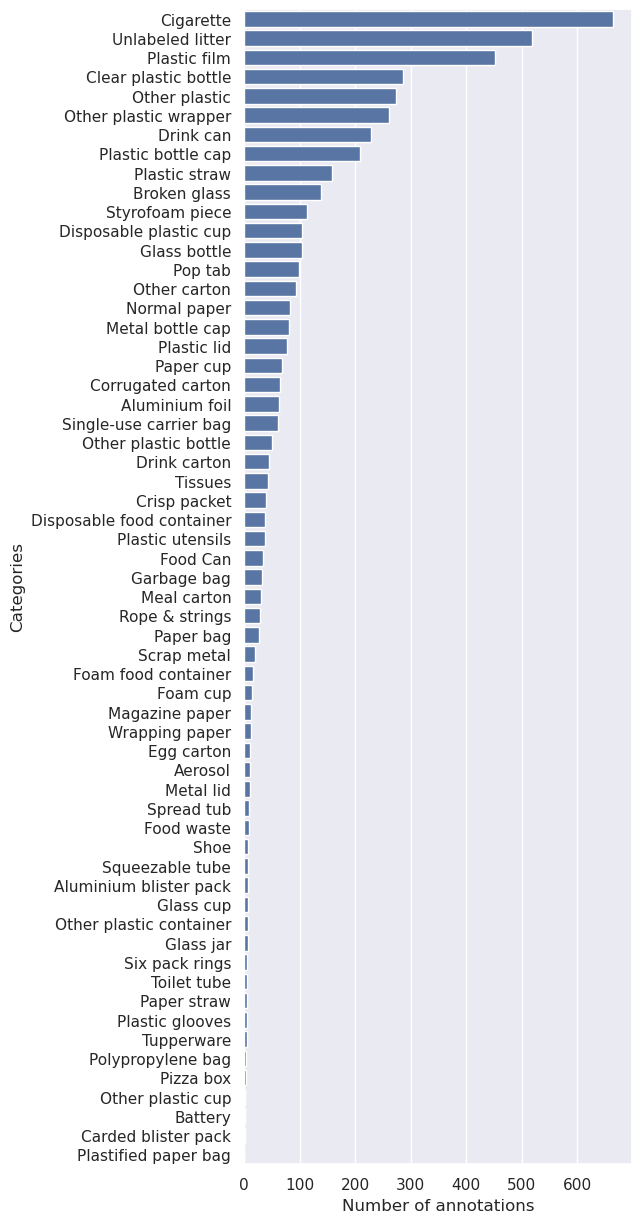

In [5]:
cats = coco.loadCats(cat_ids)
cat_names = [cat['name'] for cat in cats]

cat_histogram = np.zeros(num_cats, dtype=int)
for id in annotation_ids:
    info = coco.loadAnns(id)
    cat_histogram[info[0]['category_id']] += 1

f, ax = plt.subplots(figsize=(5,15))

df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', ascending=False)

plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")

#### Creating a torch dataset and dataloader:

In [6]:
from project.code.dataloader import *

json_to_csv(anns_file_path, 'project/annotations/')

In [7]:
from project.code.dataloader import TACODataset
from torchvision.transforms import functional as F

class ToTensor(object):
    def __call__(self, image, target):
        # Get original image size
        original_width, original_height = image.size

        # Get new image size after resizing to 224x224
        new_width, new_height = 224, 224
        # Resize image to 224x224
        image = F.resize(image, (224, 224))

        # Calculate scaling factors to adjust bounding box coordinates
        width_scale = new_width / original_width
        height_scale = new_height / original_height

        boxes = target["boxes"]

        boxes[:, 0] *= width_scale
        boxes[:, 1] *= height_scale
        boxes[:, 2] *= width_scale
        boxes[:, 3] *= height_scale

        # Convert the image to a tensor
        image = F.to_tensor(image)

        return image, target
        
np.random.seed(420)
random.seed(420)
torch.manual_seed(420)

# Create the dataset
dataset = TACODataset(dataset_path, 'project/annotations/annotations.csv', device, ToTensor())

print(len(dataset))

1500


#### Inspecting the images and annotations using our dataloader:

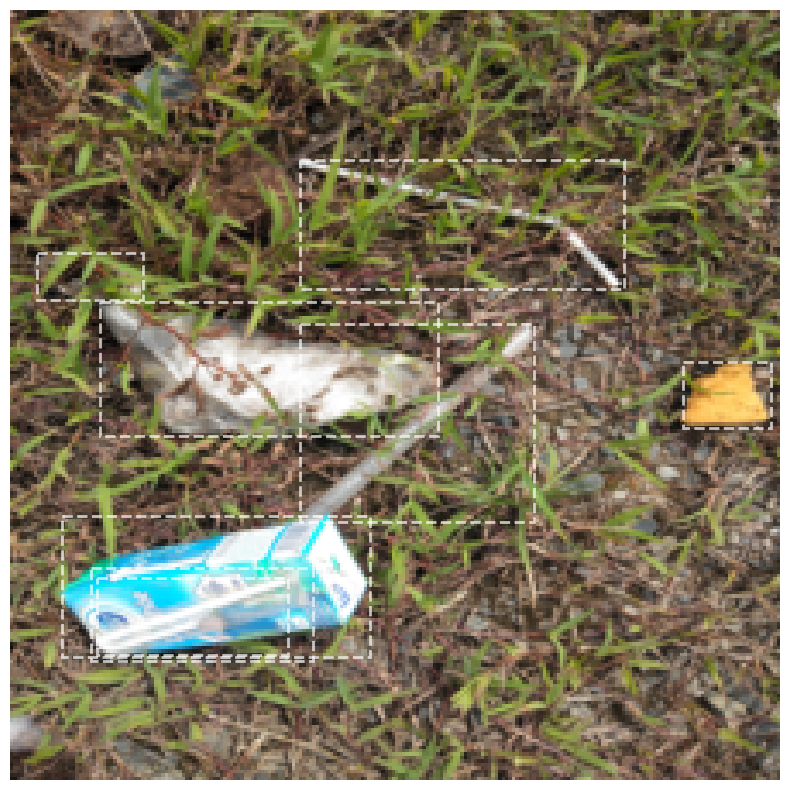

In [10]:
from project.code.utils import display_image

idx = 420

display_image(dataset, idx)

#### Train, Validation and Test split:

In [11]:
# Randomly shuffle the indices
num_samples = len(dataset)
indices = list(range(num_samples))
random.shuffle(indices)

# Define the ratio of samples for train, validation, and test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of samples for each set
train_samples = int(train_ratio * num_samples)
val_samples = int(val_ratio * num_samples)

# Split the indices into train, validation, and test sets
train_indices = indices[:train_samples]
val_indices = indices[train_samples:(train_samples + val_samples)]
test_indices = indices[(train_samples + val_samples):]

# Create data loaders for train, validation, and test sets
batch_size = 1
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.Subset(dataset, train_indices),
    batch_size=batch_size,
    shuffle=True, collate_fn=collate_fn
)

val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.Subset(dataset, val_indices),
    batch_size=batch_size,
    shuffle=False, collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.Subset(dataset, test_indices),
    batch_size=batch_size,
    shuffle=False, collate_fn=collate_fn
)

print(f"Images in Train set: ~{len(train_loader) * batch_size}")
print(f"Images in Validation set: ~{len(val_loader) * batch_size}")
print(f"Images in Test set: ~{len(test_loader) * batch_size}")

Images in Train set: ~1200
Images in Validation set: ~150
Images in Test set: ~150


#### Building our model:

In [12]:
from project.code.model import get_model
from torch.optim.lr_scheduler import StepLR

model = get_model(num_cats)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params=params, lr=0.0015, weight_decay=0.0005, betas=(0.9, 0.99))
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [30]:
def convert_to_coco_api(ds):
    coco_ds = COCO()
    # annotation IDs need to start at 1, not 0, see torchvision issue #1530
    ann_id = 1
    dataset = {"images": [], "categories": [], "annotations": []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets = ds[img_idx]
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict["id"] = image_id
        img_dict["height"] = img.shape[-2]
        img_dict["width"] = img.shape[-1]
        dataset["images"].append(img_dict)
        bboxes = targets["boxes"].clone()
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets["labels"].tolist()
        areas = targets["area"].tolist()
        iscrowd = targets["iscrowd"].tolist()
        if "masks" in targets:
            masks = targets["masks"]
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if "keypoints" in targets:
            keypoints = targets["keypoints"]
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann["image_id"] = image_id
            ann["bbox"] = bboxes[i]
            ann["category_id"] = labels[i]
            categories.add(labels[i])
            ann["area"] = areas[i]
            ann["iscrowd"] = iscrowd[i]
            ann["id"] = ann_id
            if "masks" in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if "keypoints" in targets:
                ann["keypoints"] = keypoints[i]
                ann["num_keypoints"] = sum(k != 0 for k in keypoints[i][2::3])
            dataset["annotations"].append(ann)
            ann_id += 1
    dataset["categories"] = [{"id": i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds


In [31]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
import torchvision.transforms as T
from torch._utils import _accumulate
from pycocotools.cocoeval import COCOeval

class SmoothedValue:
    def __init__(self, window_size=20):
        self.window_size = window_size
        self.reset()

    def reset(self):
        self.val = 0
        self.history = []
        self.avg = 0

    def update(self, val):
        self.val = val
        self.history.append(val)
        if len(self.history) > self.window_size:
            del self.history[0]
        self.avg = sum(self.history) / len(self.history)

# Custom MetricLogger class to track training progress
class MetricLogger:
    def __init__(self):
        self.meters = {}
        self.epoch = 0

    def update(self, **kwargs):
        self.epoch += 1
        for key, value in kwargs.items():
            if key not in self.meters:
                self.meters[key] = SmoothedValue(window_size=1)
            self.meters[key].update(value)

    def get_metrics(self):
        return {key: meter.avg for key, meter in self.meters.items()}

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger()
    metric_logger.update(epoch=epoch)

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update the metric logger
        metric_logger.update(loss=loss_value)

        if print_freq is not None and metric_logger.epoch % print_freq == 0:
            print(f"Epoch: [{epoch}]  Loss: {loss_value:.4f}")

def evaluate(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)

            # Append predictions and targets to the lists
            all_predictions.extend(output)
            all_targets.extend(targets)
    cocoGt=convert_to_coco_api(data_loader.dataset.dataset)
    # Compute mAP using coco_eval function from torchvision.ops
    coco_evaluator = COCOeval(cocoGt=cocoGt, cocoDt=cocoGt.loadRes(all_predictions), iouType='bbox')

    # Evaluate and accumulate results
    coco_evaluator.evaluate()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()


# Train the model for the specified number of epochs
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, val_loader, device=device)


Epoch: [0]  Loss: 0.7041
Epoch: [0]  Loss: 0.5455
Epoch: [0]  Loss: 0.2378
Epoch: [0]  Loss: 0.5187
Epoch: [0]  Loss: 0.4524
Epoch: [0]  Loss: 0.8859
Epoch: [0]  Loss: 1.1814
Epoch: [0]  Loss: 0.5237
Epoch: [0]  Loss: 1.5730
Epoch: [0]  Loss: 0.4099
Epoch: [0]  Loss: 1.5424
Epoch: [0]  Loss: 0.1730
creating index...
index created!
Loading and preparing results...


KeyError: 'image_id'